<a href="https://colab.research.google.com/github/Aishaamalik/Predicting-Product-Return-Probability-in-E-Commerce/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Product Return Probability in E-Commerce


In [ ]:
import pandas as pd

df = pd.read_csv("ecommerce_returns_synthetic_data.csv")

df.head()


,Order_ID,Product_ID,User_ID,Order_Date,Return_Date,Product_Category,Product_Price,Order_Quantity,Return_Reason,Return_Status,Days_to_Return,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied
0,ORD00000000,PROD00000000,USER00000000,2023-08-05,2024-08-26,Clothing,411.59,3,Changed mind,Returned,387.0,58,Male,City54,Debit Card,Next-Day,45.27
1,ORD00000001,PROD00000001,USER00000001,2023-10-09,2023-11-09,Books,288.88,3,Wrong item,Returned,31.0,68,Female,City85,Credit Card,Express,47.79
2,ORD00000002,PROD00000002,USER00000002,2023-05-06,NaN,Toys,390.03,5,NaN,Not Returned,NaN,22,Female,City30,Debit Card,Next-Day,26.64
3,ORD00000003,PROD00000003,USER00000003,2024-08-29,NaN,Toys,401.09,3,NaN,Not Returned,NaN,40,Male,City95,PayPal,Next-Day,15.37
4,ORD00000004,PROD00000004,USER00000004,2023-01-16,NaN,Books,110.09,4,NaN,Not Returned,NaN,34,Female,City80,Gift Card,Standard,16.37


# 1: Data Cleaning and Processing

 **Objective**

- Handle missing values

- Encode categorical variables appropriately

- Extract features from dates

- Normalize numerical data

- Select relevant features for modeling

##1.1 Handling Missing Values

In [ ]:
df.isnull().sum()


,0
Order_ID,0
Product_ID,0
User_ID,0
Order_Date,0
Return_Date,4948
Product_Category,0
Product_Price,0
Order_Quantity,0
Return_Reason,4948
Return_Status,0


- Return_Date, Return_Reason, and Days_to_Return have missing values.

- These are expected for orders that were not returned (i.e., Return_Status == 'Not Returned').

We’ll fill them with placeholder values

In [ ]:
df.loc[df['Return_Status'] == 'Not Returned', 'Return_Date'] = 'Not Returned'
df.loc[df['Return_Status'] == 'Not Returned', 'Return_Reason'] = 'Not Applicable'
df.loc[df['Return_Status'] == 'Not Returned', 'Days_to_Return'] = 0


##1.2 Encode Categorical Variables

 - One-hot encoding: Nominal variables with multiple values (e.g., Product_Category, Payment_Method, Shipping_Method)

- Label encoding: Binary categories (e.g., User_Gender)


### a: One-Hot Encoding (for nominal categorical features)

In [ ]:
nominal_cols = ['Product_Category', 'Payment_Method', 'Shipping_Method', 'User_Location']

nominal_cols_existing = [col for col in nominal_cols if col in df.columns]

if nominal_cols_existing:
    df = pd.get_dummies(df, columns=nominal_cols_existing, drop_first=True)
else:
    print("All nominal columns have already been encoded.")


All nominal columns have already been encoded.


### b: Label Encoding (for binary categorical features)

In [ ]:
df['User_Gender'] = df['User_Gender'].map({'Male': 1, 'Female': 0})


Final Optional Check: See remaining missing values

In [ ]:
print(df.isnull().sum())


Order_ID                0
Product_ID              0
User_ID                 0
Order_Date              0
Return_Date             0
                       ..
User_Location_City95    0
User_Location_City96    0
User_Location_City97    0
User_Location_City98    0
User_Location_City99    0
Length: 121, dtype: int64


##1.3 Convert Order_Date to Datetime and Extract Features

In [ ]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

df['Order_Month'] = df['Order_Date'].dt.month
df['Order_DayOfWeek'] = df['Order_Date'].dt.dayofweek

df.drop(columns=['Order_Date', 'Return_Date'], inplace=True)


##1.4 Normalize Numerical Features

List of Numerical Columns to Scale

In [ ]:
from sklearn.preprocessing import StandardScaler

num_cols = ['Product_Price', 'Order_Quantity', 'User_Age', 'Discount_Applied', 'Days_to_Return']

df['Days_to_Return'] = df['Days_to_Return'].fillna(0)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


##1.5 Feature Selection



### a: Drop Irrelevant / Highly Correlated Features

We'll remove columns that are:

- Identifiers (Order_ID, User_ID, etc.)

- Dates (Order_Date, Return_Date)

- Highly correlated numerical features (e.g., if correlation > 0.9)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

irrelevant_cols = ['Order_ID', 'User_ID', 'Product_ID', 'Order_Date', 'Return_Date']
df_cleaned = df.drop(columns=irrelevant_cols, errors='ignore')

if 'Return' not in df_cleaned.columns:
    if 'Return_Status' in df_cleaned.columns:
        df_cleaned['Return'] = df_cleaned['Return_Status'].map({'Returned': 1, 'Not Returned': 0})

df_cleaned = df_cleaned.drop(columns=['Return_Status'], errors='ignore')

corr_matrix = df_cleaned.select_dtypes(include=['int64', 'float64']).corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

df_cleaned = df_cleaned.drop(columns=to_drop, errors='ignore')

print(f"Dropped for high correlation: {to_drop}")


Dropped for high correlation: []



### b: Feature Importance using Random Forest



Top 15 Important Features:
                          Feature  Importance
5                Discount_Applied    0.114139
0                   Product_Price    0.114044
3                        User_Age    0.094540
2                  Days_to_Return    0.079197
114                   Order_Month    0.068835
115               Order_DayOfWeek    0.055731
1                  Order_Quantity    0.046083
14       Shipping_Method_Standard    0.018187
13       Shipping_Method_Next-Day    0.017285
12          Payment_Method_PayPal    0.016184
10      Payment_Method_Debit Card    0.015744
11       Payment_Method_Gift Card    0.015544
8           Product_Category_Home    0.014902
6       Product_Category_Clothing    0.014858
7    Product_Category_Electronics    0.014852


<ipython-input-101-9e2ec1834a44>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-101-9e2ec1834a44>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


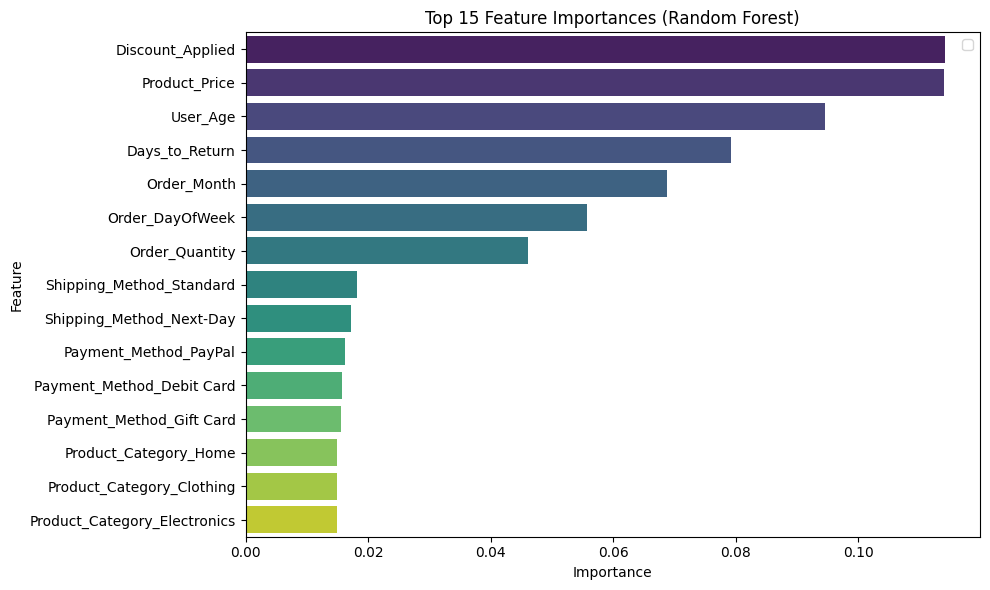

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_cleaned.drop(columns=['Return'])
y = df_cleaned['Return']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 15 Important Features:")
print(importances.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances.head(15),
    palette='viridis',
)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.legend()
plt.show()


**downloading df_cleaned**

In [ ]:
df_cleaned.to_csv('cleaned_ecommerce_data.csv', index=False)

from google.colab import files
files.download('cleaned_ecommerce_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

#2: Data Understanding & Exploration

## 1: Dataset


###1.1 Load and Inspect the Cleaned Dataset


In [ ]:
print(" Number of Rows and Columns:", df_cleaned.shape)

print("\nColumn Names:")
print(df_cleaned.columns.tolist())


 Number of Rows and Columns: (10000, 117)

Column Names:
['Product_Price', 'Order_Quantity', 'Days_to_Return', 'User_Age', 'User_Gender', 'Discount_Applied', 'Product_Category_Clothing', 'Product_Category_Electronics', 'Product_Category_Home', 'Product_Category_Toys', 'Payment_Method_Debit Card', 'Payment_Method_Gift Card', 'Payment_Method_PayPal', 'Shipping_Method_Next-Day', 'Shipping_Method_Standard', 'User_Location_City10', 'User_Location_City100', 'User_Location_City11', 'User_Location_City12', 'User_Location_City13', 'User_Location_City14', 'User_Location_City15', 'User_Location_City16', 'User_Location_City17', 'User_Location_City18', 'User_Location_City19', 'User_Location_City2', 'User_Location_City20', 'User_Location_City21', 'User_Location_City22', 'User_Location_City23', 'User_Location_City24', 'User_Location_City25', 'User_Location_City26', 'User_Location_City27', 'User_Location_City28', 'User_Location_City29', 'User_Location_City3', 'User_Location_City30', 'User_Location_Cit

###1.2 Understand Feature Data Types & Missing Values

In [ ]:
print("Feature Data Types & Missing Value Summary:")
df_cleaned.info()


Feature Data Types & Missing Value Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 117 entries, Product_Price to Return
dtypes: bool(108), float64(6), int32(2), int64(1)
memory usage: 1.6 MB


###1.3 Preview the Data (First Few Rows)

In [ ]:
df_cleaned.head()


,Product_Price,Order_Quantity,Days_to_Return,User_Age,User_Gender,Discount_Applied,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Home,Product_Category_Toys,...,User_Location_City93,User_Location_City94,User_Location_City95,User_Location_City96,User_Location_City97,User_Location_City98,User_Location_City99,Order_Month,Order_DayOfWeek,Return
0,1.114392,-0.004336,1.823908,0.901627,NaN,1.411842,True,False,False,False,...,False,False,False,False,False,False,False,8,5,0
1,0.255540,-0.004336,0.142911,1.554742,NaN,1.587297,False,False,False,False,...,False,False,False,False,False,False,False,10,0,1
2,0.963493,1.417410,-0.003468,-1.449591,NaN,0.114731,False,False,False,True,...,False,False,False,False,False,False,False,5,5,1
3,1.040902,-0.004336,-0.003468,-0.273982,NaN,-0.669942,False,False,False,True,...,False,False,True,False,False,False,False,8,3,0
4,-0.995819,0.706537,-0.003468,-0.665852,NaN,-0.600317,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1


### 1.4 Understand the Target Variable Return (Binary: Yes / No)

In [ ]:
print(" Target Variable - 'Return' (0 = Not Returned, 1 = Returned):\n")
print(df_cleaned['Return'].value_counts())

print("\n Percentage Distribution:")
print(df_cleaned['Return'].value_counts(normalize=True) * 100)


 Target Variable - 'Return' (0 = Not Returned, 1 = Returned):

Return
1    5010
0    4990
Name: count, dtype: int64

 Percentage Distribution:
Return
1    50.1
0    49.9
Name: proportion, dtype: float64


 Balanced Dataset: The class distribution is nearly perfectly balanced, meaning:

- No need for oversampling (SMOTE) or undersampling.

- You can train classification models directly without worrying about imbalance bias.

## 2: Exploratory Data Analysis (EDA)

###2.1 Distribution of Target Variable (Return)

<ipython-input-91-28e00f00b87e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Return', data=df, palette='pastel')


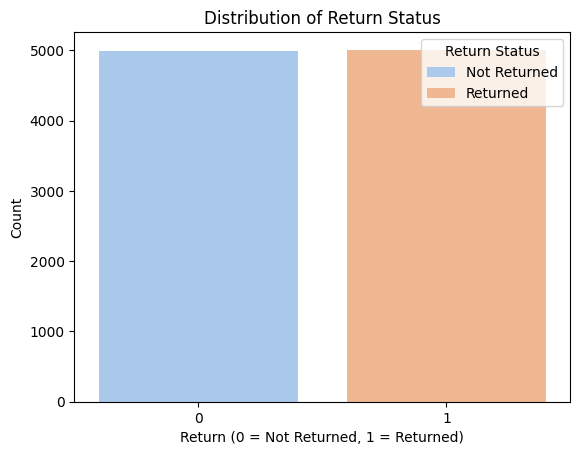

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ecommerce_data.csv')

return_counts = df['Return'].value_counts()
return_percent = df['Return'].value_counts(normalize=True) * 100

ax = sns.countplot(x='Return', data=df, palette='pastel')

plt.title('Distribution of Return Status')
plt.xlabel('Return (0 = Not Returned, 1 = Returned)')
plt.ylabel('Count')

plt.legend(title='Return Status', labels=['Not Returned', 'Returned'])

plt.show()


### 2.2 Univariate Analysis

####A. Product Price

<ipython-input-81-30bb7a40c619>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


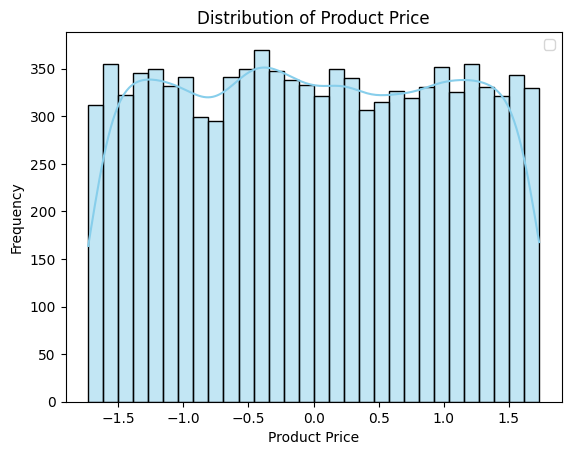

In [ ]:
sns.histplot(df['Product_Price'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Product Price')
plt.xlabel('Product Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


####B. Order Quantity

<ipython-input-82-8797704a5e22>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


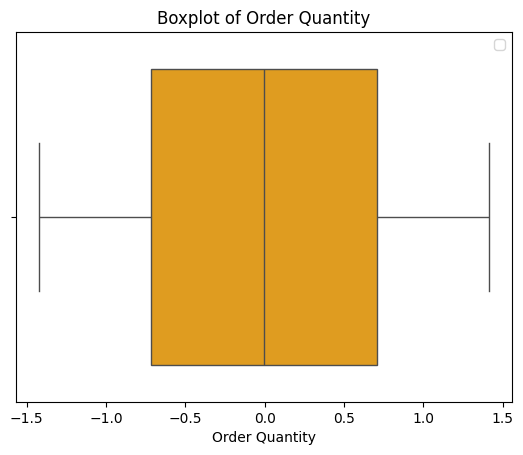

In [ ]:
sns.boxplot(x=df['Order_Quantity'], color='orange')
plt.title('Boxplot of Order Quantity')
plt.xlabel('Order Quantity')
plt.legend()
plt.show()


####C. Customer Age

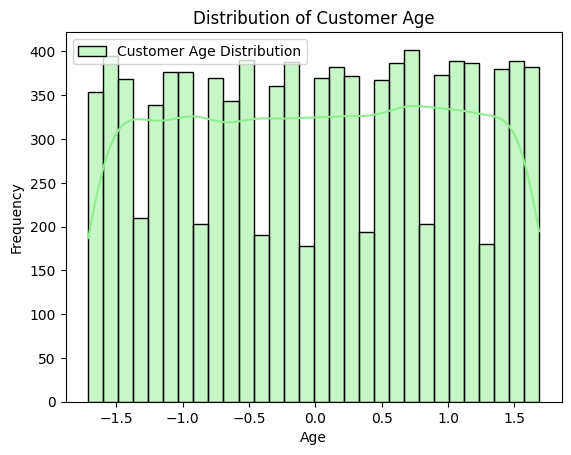

In [ ]:
sns.histplot(df['User_Age'], bins=30, kde=True, color='lightgreen', label='Customer Age Distribution')
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### 2.3 Bivariate Analysis (Features vs Return)

####A. Price vs Return

<ipython-input-84-2131c515d7e7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='Product_Price', data=df, palette='Set2')
<ipython-input-84-2131c515d7e7>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


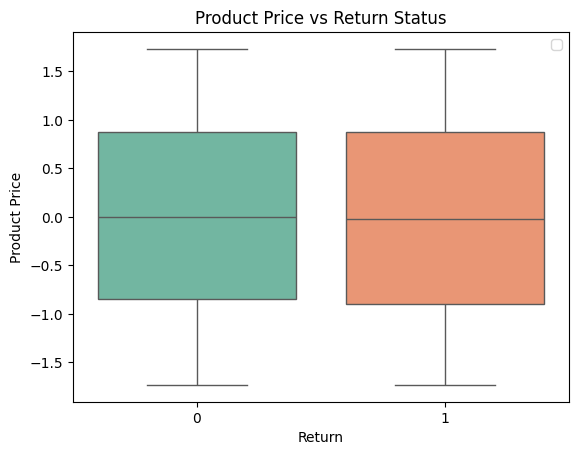

In [ ]:
sns.boxplot(x='Return', y='Product_Price', data=df, palette='Set2')
plt.title('Product Price vs Return Status')
plt.xlabel('Return')
plt.ylabel('Product Price')
plt.legend()
plt.show()


####B. User Age vs Return

<ipython-input-95-1bf48d97dc51>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='User_Age', data=df, palette='Set3', label='Product Price by Return')


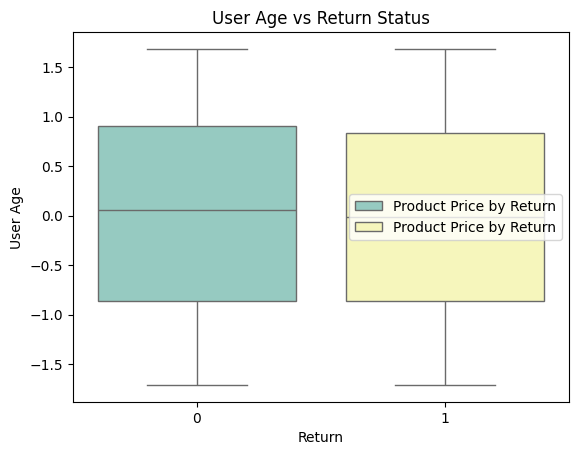

In [ ]:
sns.boxplot(x='Return', y='User_Age', data=df, palette='Set3', label='Product Price by Return')
plt.title('User Age vs Return Status')
plt.xlabel('Return')
plt.ylabel('User Age')
plt.legend()
plt.show()


####C. Discount vs Return

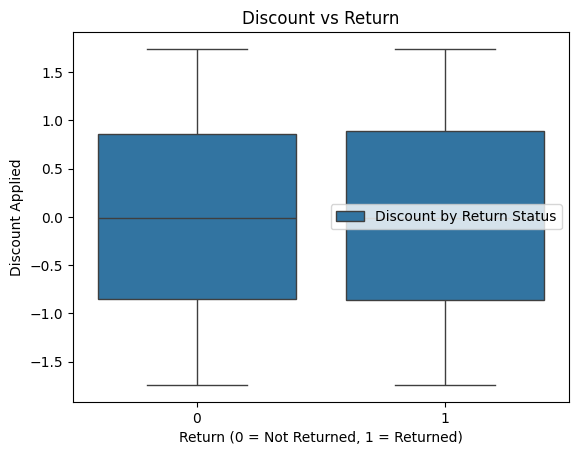

In [ ]:

sns.boxplot(x='Return', y='Discount_Applied', data=df, label='Discount by Return Status')
plt.title('Discount vs Return')
plt.xlabel('Return (0 = Not Returned, 1 = Returned)')
plt.ylabel('Discount Applied')
plt.legend()
plt.show()


### 2.4 Grouped Aggregations

####A. Return Rate by Product Category


<ipython-input-97-efcb0746b733>:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cat_return_rate = df_cat.groupby(lambda x: x, axis=1).mean().mean().sort_values(ascending=False)


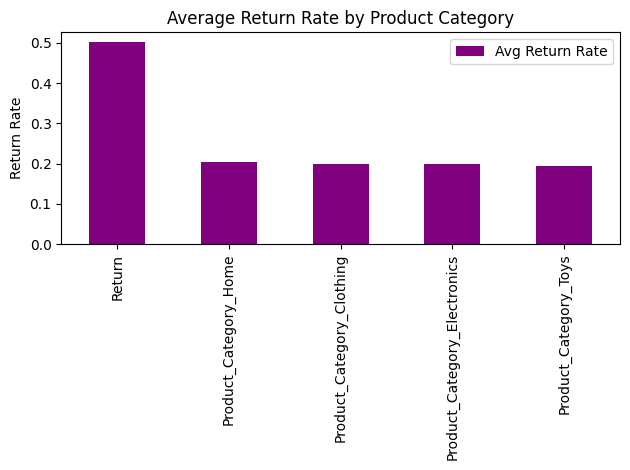

In [ ]:
product_cols = [col for col in df.columns if 'Product_Category' in col]
df_cat = df[['Return'] + product_cols]
cat_return_rate = df_cat.groupby(lambda x: x, axis=1).mean().mean().sort_values(ascending=False)

cat_return_rate.plot(kind='bar', color='purple', label='Avg Return Rate')

plt.title('Average Return Rate by Product Category')
plt.ylabel('Return Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()


####B. Return Rate by Shipping Method

<ipython-input-98-1ef4742c029c>:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ship_return_rate = df_ship.groupby(lambda x: x, axis=1).mean().mean().sort_values(ascending=False)


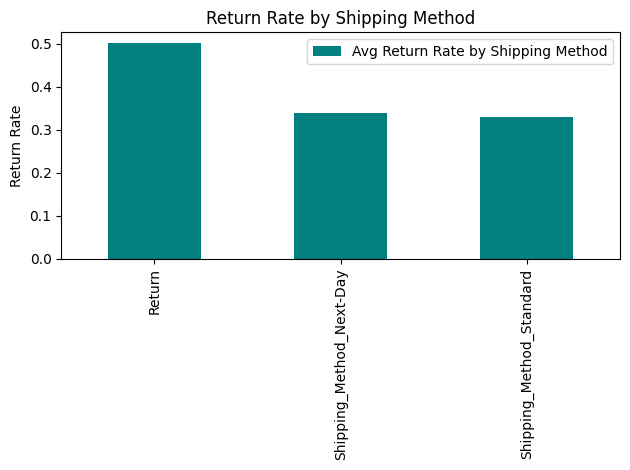

In [ ]:
shipping_cols = [col for col in df.columns if 'Shipping_Method' in col]
df_ship = df[['Return'] + shipping_cols]
ship_return_rate = df_ship.groupby(lambda x: x, axis=1).mean().mean().sort_values(ascending=False)

ship_return_rate.plot(kind='bar', color='teal', label='Avg Return Rate by Shipping Method')

plt.title('Return Rate by Shipping Method')
plt.ylabel('Return Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()


### 2.5 Correlation Matrix

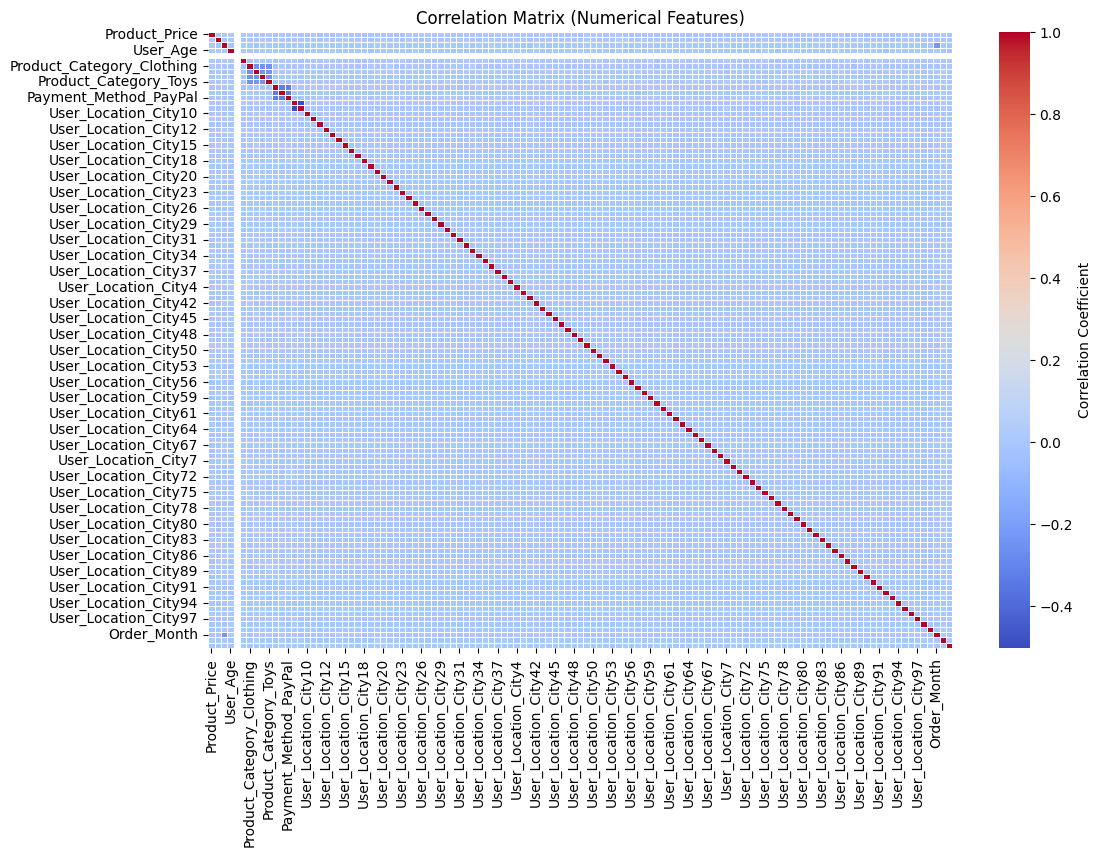

In [ ]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

## 3: Data Visualizations

### 3.1 Bar Charts — Return % by Category

We'll compute return rates for various categorical variables and plot them.

#### a. Return % by Product Category (top 5)

      Category  ReturnRate
1  Electronics   50.780856
0     Clothing   49.800000
2         Home   49.458128
3         Toys   49.382716


<ipython-input-115-f6fd6605ec5e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_cat_df, x='ReturnRate', y='Category', palette='Blues_d')


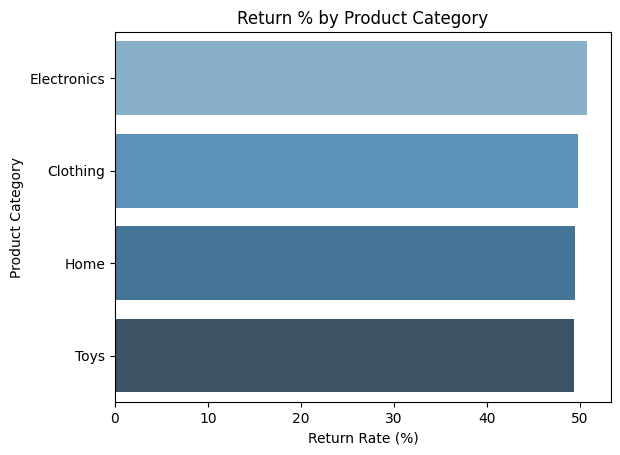

In [ ]:
product_cats = [col for col in df.columns if col.startswith('Product_Category_')]

product_cat_df = pd.DataFrame({
    'Category': [col.split('_')[-1] for col in product_cats],
    'ReturnRate': [df[df[col] == 1]['Return'].mean() * 100 for col in product_cats]
})

product_cat_df = product_cat_df.sort_values(by='ReturnRate', ascending=False)

print(product_cat_df)

sns.barplot(data=product_cat_df, x='ReturnRate', y='Category', palette='Blues_d')
plt.title("Return % by Product Category")
plt.xlabel("Return Rate (%)")
plt.ylabel("Product Category")
plt.show()


The table shows return rates by category, with Electronics having the highest at 50.78%, followed by Clothing, Home, and Toys.

#### b. Return % by Shipping Method

  ShippingMethod  ReturnRate
0       Next-Day   49.823217
1       Standard   50.454545


<ipython-input-116-a37bf088c052>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ship_df, x='ReturnRate', y='ShippingMethod', palette='magma')


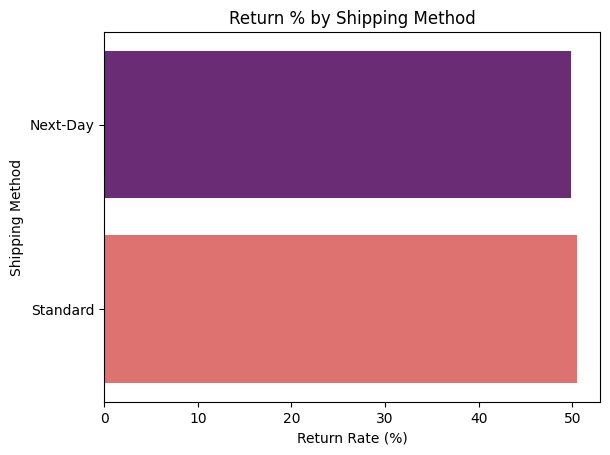

In [ ]:
ship_cols = [col for col in df.columns if col.startswith('Shipping_Method_')]

ship_df = pd.DataFrame({
    'ShippingMethod': [col.split('_')[-1] for col in ship_cols],
    'ReturnRate': [df[df[col] == 1]['Return'].mean() * 100 for col in ship_cols]
})

print(ship_df)

sns.barplot(data=ship_df, x='ReturnRate', y='ShippingMethod', palette='magma')
plt.title("Return % by Shipping Method")
plt.xlabel("Return Rate (%)")
plt.ylabel("Shipping Method")
plt.show()

#### c. Return % by Payment Method

  PaymentMethod  ReturnRate
0    Debit Card   50.677291
1     Gift Card   50.808041
2        PayPal   50.161290


<ipython-input-117-55c07f13baa4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pay_df, x='ReturnRate', y='PaymentMethod', palette='coolwarm')


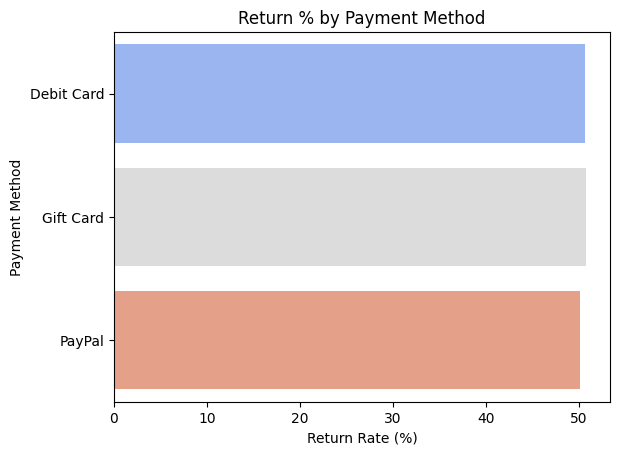

In [ ]:
pay_cols = [col for col in df.columns if col.startswith('Payment_Method_')]

pay_df = pd.DataFrame({
    'PaymentMethod': [col.split('_')[-1] for col in pay_cols],
    'ReturnRate': [df[df[col] == 1]['Return'].mean() * 100 for col in pay_cols]
})

print(pay_df)

sns.barplot(data=pay_df, x='ReturnRate', y='PaymentMethod', palette='coolwarm')
plt.title("Return % by Payment Method")
plt.xlabel("Return Rate (%)")
plt.ylabel("Payment Method")
plt.show()

#### d. Return % by Order Month

    Order_Month     Return
0             1  49.706917
1             2  49.182390
2             3  50.527550
3             4  49.584816
4             5  52.494062
5             6  50.799508
6             7  48.092486
7             8  50.182260
8             9  50.963855
9            10  50.975890
10           11  49.541284
11           12  49.116608


<ipython-input-118-c5d395fdeb7f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=month_df, x='Order_Month', y='Return', palette='cividis')


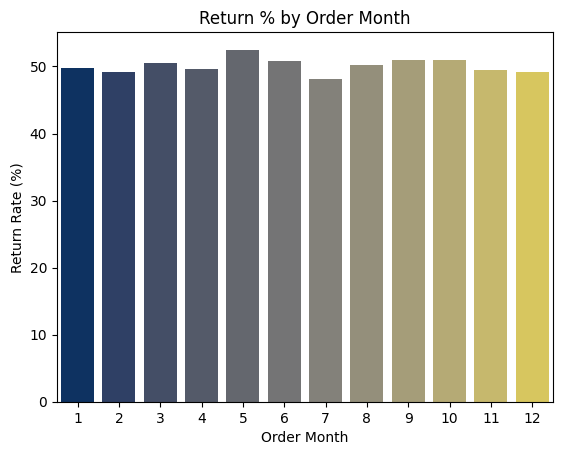

In [ ]:

month_df = df.groupby('Order_Month')['Return'].mean().reset_index()
month_df['Return'] = month_df['Return'] * 100

print(month_df)

sns.barplot(data=month_df, x='Order_Month', y='Return', palette='cividis')
plt.title("Return % by Order Month")
plt.xlabel("Order Month")
plt.ylabel("Return Rate (%)")
plt.show()

#### e. Return % by Day of Week

   Order_DayOfWeek     Return
0                0  49.869452
1                1  48.621908
2                2  49.927326
3                3  48.763251
4                4  51.442646
5                5  50.554017
6                6  51.539012


<ipython-input-119-c8c7149ff5e6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_df, x='Order_DayOfWeek', y='Return', palette='viridis')


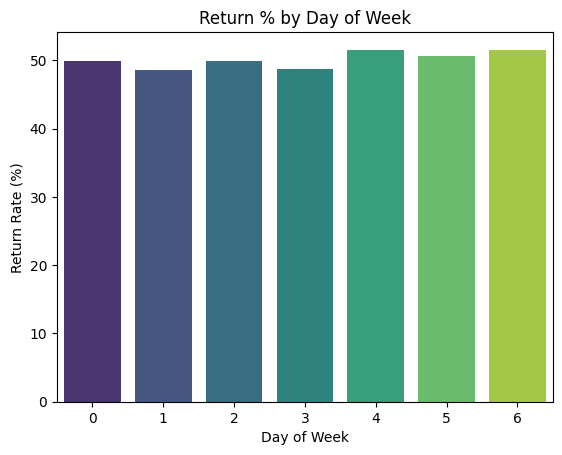

In [ ]:
dow_df = df.groupby('Order_DayOfWeek')['Return'].mean().reset_index()
dow_df['Return'] = dow_df['Return'] * 100

print(dow_df)

sns.barplot(data=dow_df, x='Order_DayOfWeek', y='Return', palette='viridis')
plt.title("Return % by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Return Rate (%)")
plt.show()

### 3.2 Histograms
These will help us understand distributions of key numeric features.


#### a. Histogram: Product Price

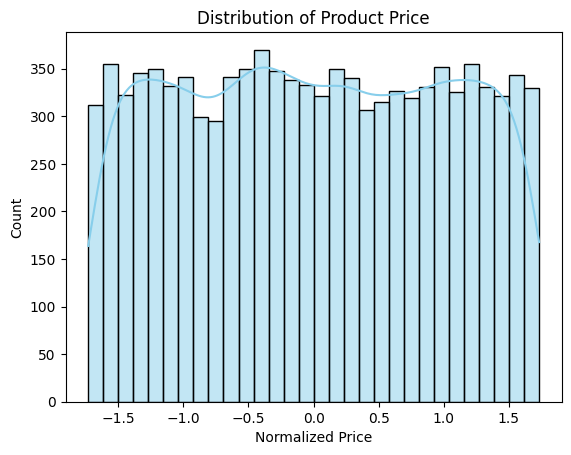

In [ ]:
sns.histplot(df['Product_Price'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Product Price")
plt.xlabel("Normalized Price")
plt.show()

#### b. Histogram: Days to Return

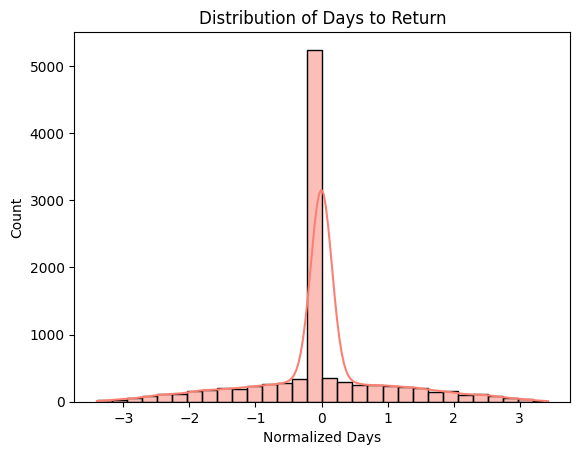

In [ ]:
sns.histplot(df['Days_to_Return'], kde=True, bins=30, color='salmon')
plt.title("Distribution of Days to Return")
plt.xlabel("Normalized Days")
plt.show()

#### c. Histogram: Discount Applied

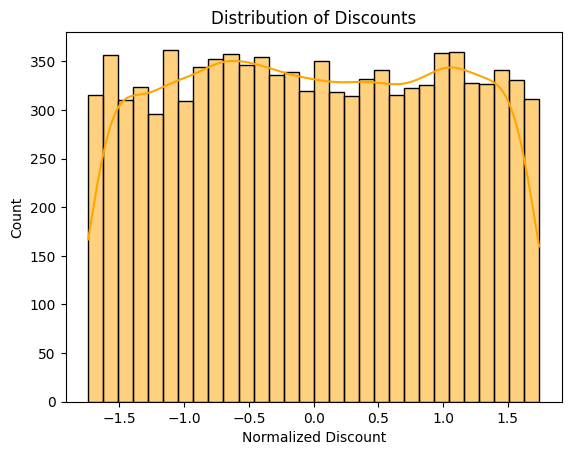

In [ ]:
sns.histplot(df['Discount_Applied'], kde=True, bins=30, color='orange')
plt.title("Distribution of Discounts")
plt.xlabel("Normalized Discount")
plt.show()

#### d. Histogram: Order Quantity

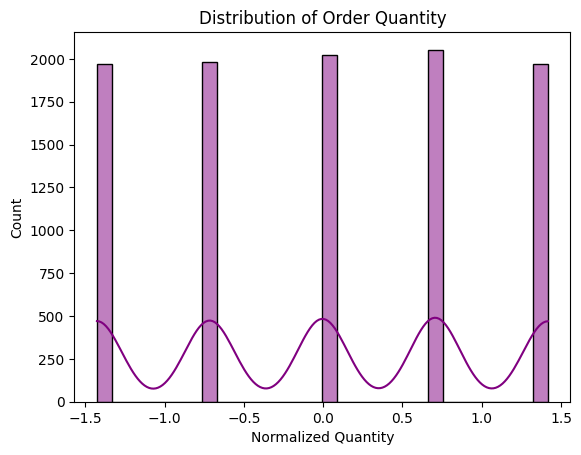

In [ ]:
sns.histplot(df['Order_Quantity'], kde=True, bins=30, color='purple')
plt.title("Distribution of Order Quantity")
plt.xlabel("Normalized Quantity")
plt.show()

#### e. Histogram: User Age

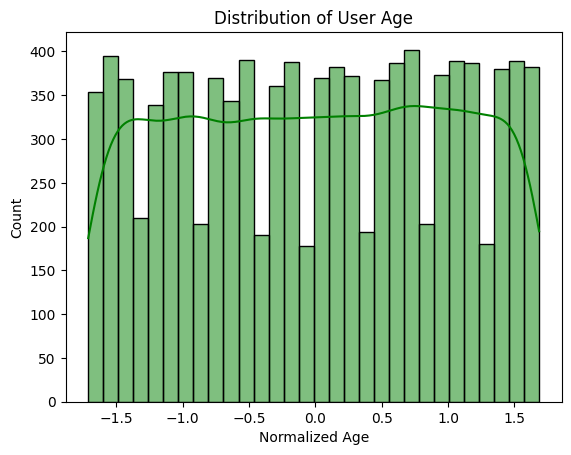

In [ ]:
sns.histplot(df['User_Age'], kde=True, bins=30, color='green')
plt.title("Distribution of User Age")
plt.xlabel("Normalized Age")
plt.show()

### 3.3 Heatmaps — Correlation Matrix

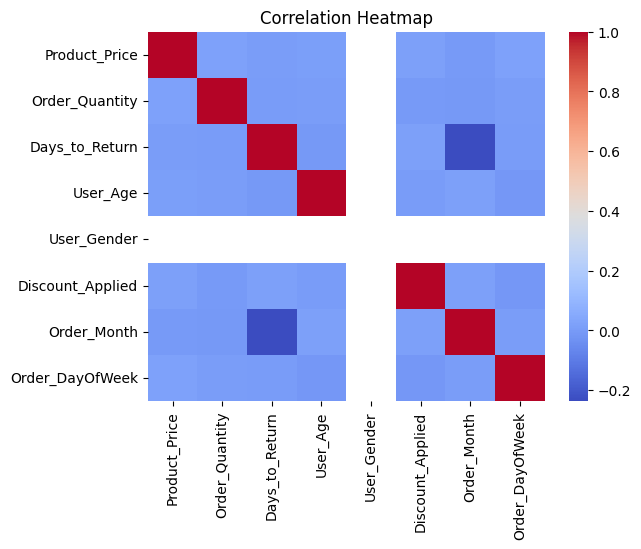

In [ ]:
numeric_cols = df.select_dtypes(include='number').drop(columns=['Return'])

corr = numeric_cols.corr()

sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

#### a. Focused Heatmap: Top 10 Correlated with Return

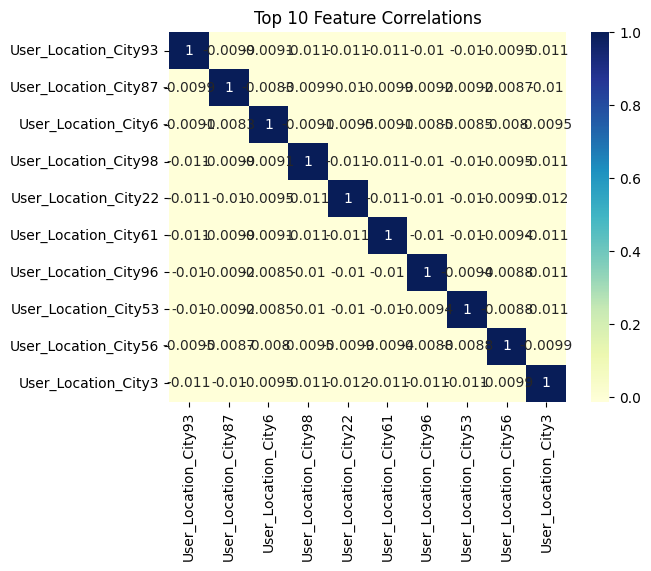

In [ ]:
top_corr = df.corr()['Return'].abs().sort_values(ascending=False).drop('Return').head(10).index
focused_corr = df[top_corr].corr()
sns.heatmap(focused_corr, annot=True, cmap='YlGnBu')
plt.title("Top 10 Feature Correlations")
plt.show()

#### b. Heatmap: Correlation with Product Features

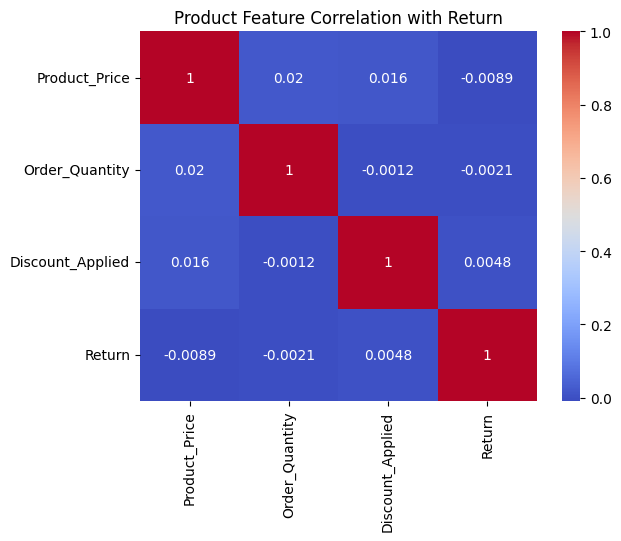

In [ ]:
prod_feats = ['Product_Price', 'Order_Quantity', 'Discount_Applied']
sns.heatmap(df[prod_feats + ['Return']].corr(), annot=True, cmap='coolwarm')
plt.title("Product Feature Correlation with Return")
plt.show()

#### c. Heatmap: User Demographics

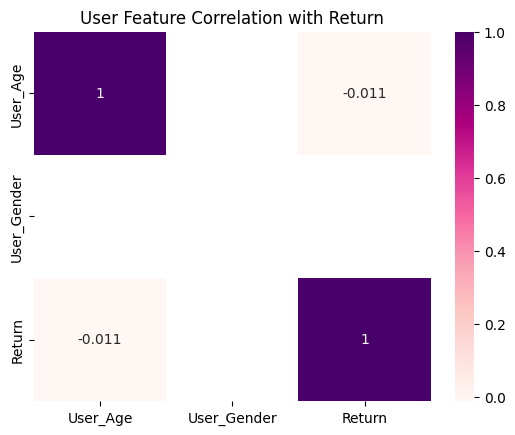

In [ ]:
user_feats = ['User_Age', 'User_Gender']
sns.heatmap(df[user_feats + ['Return']].corr(), annot=True, cmap='RdPu')
plt.title("User Feature Correlation with Return")
plt.show()


#### d. Heatmap: Order Metadata

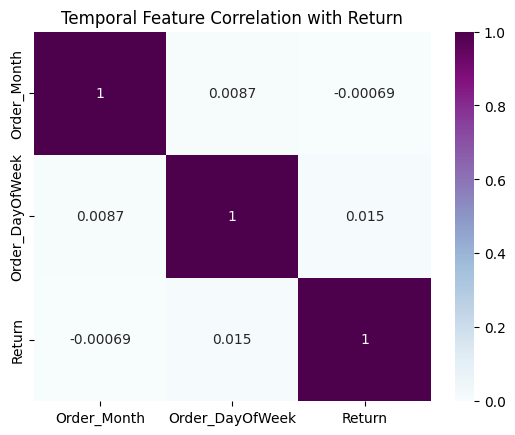

In [ ]:
meta_feats = ['Order_Month', 'Order_DayOfWeek']
sns.heatmap(df[meta_feats + ['Return']].corr(), annot=True, cmap='BuPu')
plt.title("Temporal Feature Correlation with Return")
plt.show()

### 3.4 Boxplots

Boxplots show distribution spread, outliers, and medians.

#### a. Product Price vs Return

<ipython-input-130-14ce6ac851a2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='Product_Price', data=df, palette='Set2')


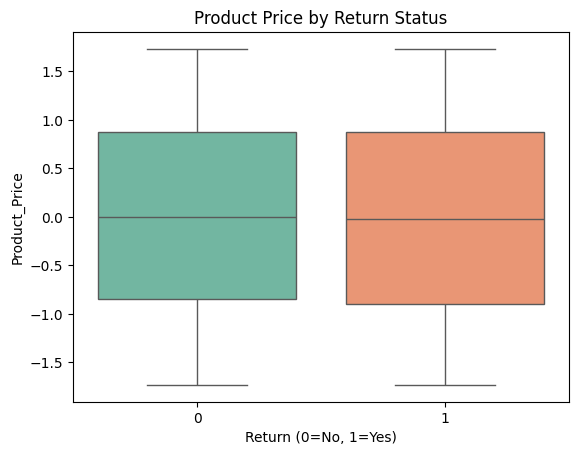

In [ ]:
sns.boxplot(x='Return', y='Product_Price', data=df, palette='Set2')
plt.title("Product Price by Return Status")
plt.xlabel("Return (0=No, 1=Yes)")
plt.show()

#### b. Discount Applied vs Return

<ipython-input-131-5af6b5d99abb>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='Discount_Applied', data=df, palette='Set1')


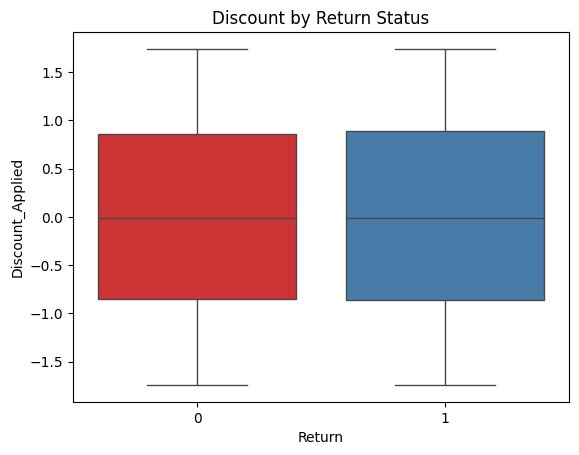

In [ ]:
sns.boxplot(x='Return', y='Discount_Applied', data=df, palette='Set1')
plt.title("Discount by Return Status")
plt.show()


#### c. Days to Return vs Return

<ipython-input-132-7043ee88aba2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='Days_to_Return', data=df, palette='Set3')


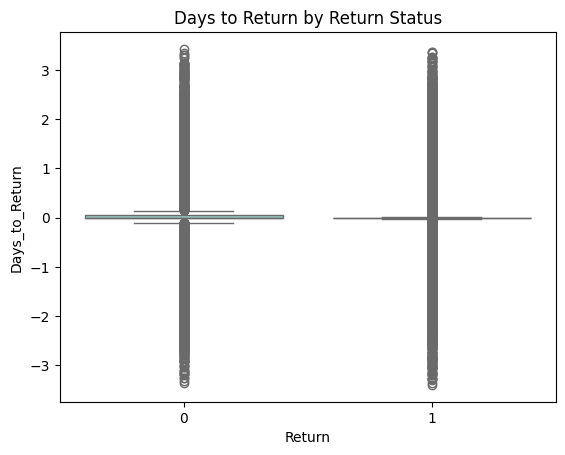

In [ ]:
sns.boxplot(x='Return', y='Days_to_Return', data=df, palette='Set3')
plt.title("Days to Return by Return Status")
plt.show()

#### d. Order Quantity vs Return

<ipython-input-133-2b318dc60f6a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='Order_Quantity', data=df, palette='cool')


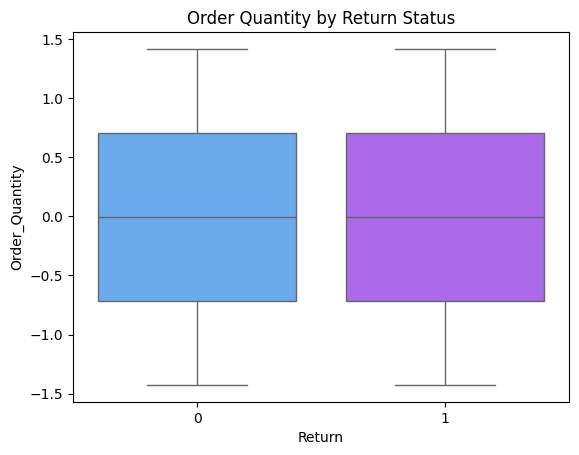

In [ ]:
sns.boxplot(x='Return', y='Order_Quantity', data=df, palette='cool')
plt.title("Order Quantity by Return Status")
plt.show()

#### e. User Age vs Return

<ipython-input-134-d99905a22149>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Return', y='User_Age', data=df, palette='muted')


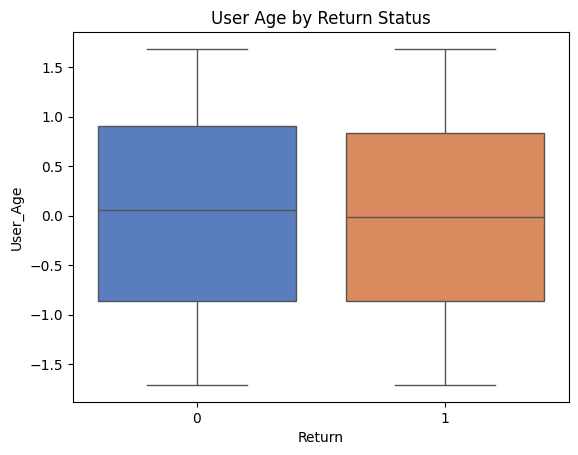

In [ ]:
sns.boxplot(x='Return', y='User_Age', data=df, palette='muted')
plt.title("User Age by Return Status")
plt.show()

---


# 3: Feature Engineering Ideas

##1. High-Return Category Indicator

In [ ]:
product_cat_cols = [col for col in df.columns if col.startswith('Product_Category_')]
cat_return_rates = {col: df[df[col] == 1]['Return'].mean() for col in product_cat_cols}

high_return_threshold = 0.6

df['High_Return_Category'] = df[product_cat_cols].apply(
    lambda row: int(any(row[col] == 1 and cat_return_rates[col] > high_return_threshold for col in product_cat_cols)),
    axis=1
)


## 2. Price Brackets (Low / Medium / High)

Objective: Bucket Product_Price into categorical bins.

In [ ]:
df['Price_Bracket'] = pd.qcut(df['Product_Price'], q=3, labels=['Low', 'Medium', 'High'])


## 3. Shipping Delay Flag

Assuming Days_to_Return can act as a proxy for shipping + return time.

In [ ]:
df['Shipping_Delay'] = (df['Days_to_Return'] > 10).astype(int)


---

# 4: E-Commerce Product Return Prediction

##1: Install Dependencies (XGBoost, LightGBM)

In [ ]:
!pip install xgboost lightgbm


## 2: Import Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


##3: Load the Dataset

In [ ]:
df = pd.read_csv("cleaned_ecommerce_data.csv")
df.head()


,Product_Price,Order_Quantity,Days_to_Return,User_Age,User_Gender,Discount_Applied,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Home,Product_Category_Toys,...,User_Location_City93,User_Location_City94,User_Location_City95,User_Location_City96,User_Location_City97,User_Location_City98,User_Location_City99,Order_Month,Order_DayOfWeek,Return
0,1.114392,-0.004336,1.823908,0.901627,NaN,1.411842,True,False,False,False,...,False,False,False,False,False,False,False,8,5,0
1,0.255540,-0.004336,0.142911,1.554742,NaN,1.587297,False,False,False,False,...,False,False,False,False,False,False,False,10,0,1
2,0.963493,1.417410,-0.003468,-1.449591,NaN,0.114731,False,False,False,True,...,False,False,False,False,False,False,False,5,5,1
3,1.040902,-0.004336,-0.003468,-0.273982,NaN,-0.669942,False,False,False,True,...,False,False,True,False,False,False,False,8,3,0
4,-0.995819,0.706537,-0.003468,-0.665852,NaN,-0.600317,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1


## 4: Preprocess the Data

In [ ]:
df = pd.read_csv('cleaned_ecommerce_data.csv')
df = df.drop(columns=['User_Gender'])


for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].mean())

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

target_col = 'Return'
X = df.drop(columns=[target_col])
y = df[target_col]

X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

print("Final shape before scaling:", X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Final shape before scaling: (10000, 115)


## 5: Stratified K-Fold Setup

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## 6: Train and Evaluate Models

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

results = {}

for name, model in models.items():
    print(f"\n {name}")
    acc_scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='accuracy')
    roc_scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='roc_auc')
    results[name] = {
        'Accuracy': np.mean(acc_scores),
        'ROC AUC': np.mean(roc_scores)
    }
    print(f"Avg Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Avg ROC AUC: {np.mean(roc_scores):.4f}")



 Logistic Regression
Avg Accuracy: 0.4952
Avg ROC AUC: 0.4924

 Decision Tree
Avg Accuracy: 0.5018
Avg ROC AUC: 0.5028

 Random Forest
Avg Accuracy: 0.4963
Avg ROC AUC: 0.5006

 XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:38:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:38:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:38:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Avg Accuracy: 0.4862
Avg ROC AUC: 0.4844

 LightGBM
[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000
Avg Accuracy: 0.4946
Avg ROC AUC: 0.4923


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 7: Train/Test Split for Final Evaluation


 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51       998
           1       0.50      0.47      0.49      1002

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000


 Confusion Matrix:


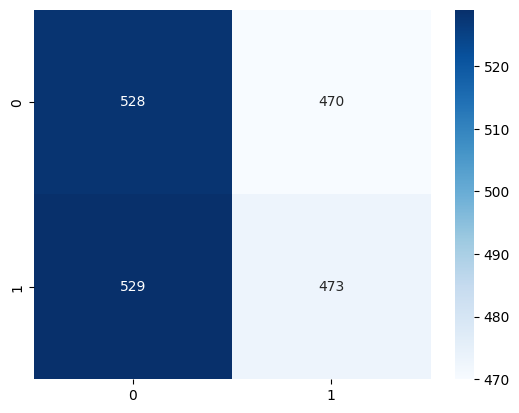


 ROC AUC Score: 0.5023210092840371


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

final_model = RandomForestClassifier()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

print("\n ROC AUC Score:", roc_auc_score(y_test, y_proba))


## 8: Compare All Models


Model Comparison:
                      Accuracy   ROC AUC
Decision Tree          0.5018  0.502784
Random Forest          0.4963  0.500581
Logistic Regression    0.4952  0.492388
LightGBM               0.4946  0.492268
XGBoost                0.4862  0.484427


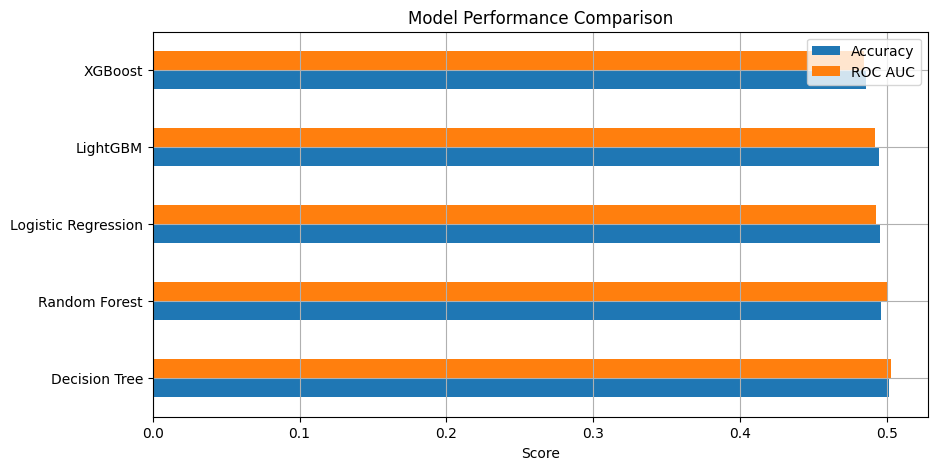

In [ ]:
result_df = pd.DataFrame(results).T.sort_values(by='ROC AUC', ascending=False)
print("\nModel Comparison:\n", result_df)

result_df.plot(kind='barh', figsize=(10, 5))
plt.title("Model Performance Comparison")
plt.xlabel("Score")
plt.grid()
plt.show()


## 9: Model Evaluation Metrics (for the Best Model)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(" Evaluation Metrics:")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-Score:  {f1:.4f}")
print(f" ROC-AUC:   {roc_auc:.4f}")


 Evaluation Metrics:
 Accuracy:  0.5005
 Precision: 0.5016
 Recall:    0.4721
 F1-Score:  0.4864
 ROC-AUC:   0.5023


### a. Confusion Matrix

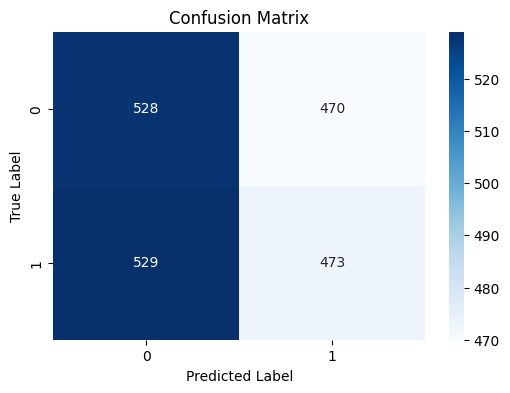

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### b. ROC Curve

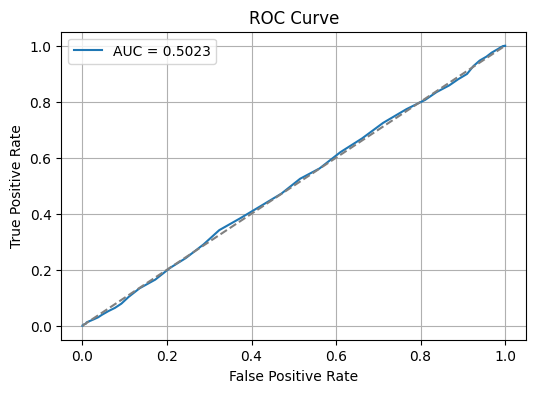

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


----

# 5:  Hyperparameter Tuning

Import Needed Tools




In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


## 1: Random Forest - RandomizedSearchCV

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

print("Best RF Params:", rf_random_search.best_params_)
print("Best RF ROC AUC Score:", rf_random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}
Best RF ROC AUC Score: 0.4977884213880793


## 2: XGBoost - RandomizedSearchCV

In [ ]:
xgb_params = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.5, 0.7, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

print("Best XGB Params:", xgb_random_search.best_params_)
print("Best XGB ROC AUC Score:", xgb_random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB Params: {'subsample': 1, 'n_estimators': 300, 'max_depth': 10, 'eta': 0.1, 'colsample_bytree': 1}
Best XGB ROC AUC Score: 0.4967815592334044


## 3: LightGBM - RandomizedSearchCV

In [ ]:
lgb_params = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20]
}

lgb = LGBMClassifier(random_state=42)

lgb_random_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgb_params,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lgb_random_search.fit(X_train, y_train)

print("Best LGBM Params:", lgb_random_search.best_params_)
print("Best LGBM ROC AUC Score:", lgb_random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000
Best LGBM Params: {'num_leaves': 15, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.01}
Best LGBM ROC AUC Score: 0.4943191961517345


---

#6: Model Interpretation

## 1: Feature Importance Plots

###  For Random Forest:

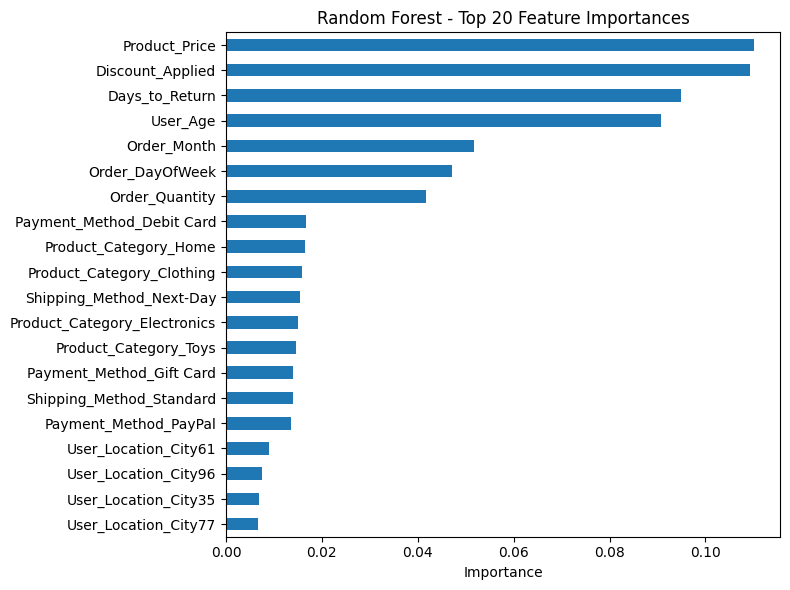

In [ ]:
best_rf = rf_random_search.best_estimator_

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(8, 6))
plt.title("Random Forest - Top 20 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 2: Partial Dependence Plots (PDP)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

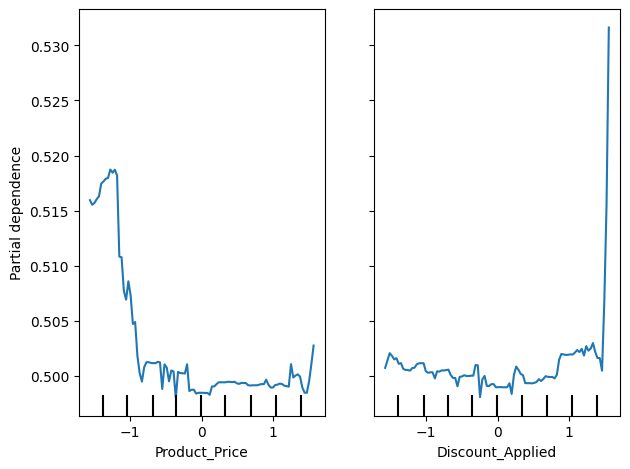

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

top_features = importances.sort_values(ascending=False).head(2).index.tolist()

PartialDependenceDisplay.from_estimator(best_rf, X, features=top_features)
plt.tight_layout()
plt.show()


----

#Predictions on real values from your dataset

In [ ]:
final_model = RandomForestClassifier()
final_model.fit(X_scaled, y)

random_indices = np.random.choice(len(X), size=5, replace=False)
X_sample = X.iloc[random_indices]
y_true = y.iloc[random_indices]

X_sample_scaled = scaler.transform(X_sample)

predictions = final_model.predict(X_sample_scaled)
probs = final_model.predict_proba(X_sample_scaled)[:, 1]

for i in range(len(X_sample)):
    print(f"Sample #{i+1}")
    print(f"True Label: {y_true.iloc[i]}")
    print(f"Predicted Label: {predictions[i]}")
    print(f"Predicted Probability of Return (class=1): {probs[i]:.4f}")
    print("-" * 40)


Sample #1
True Label: 1
Predicted Label: 1
Predicted Probability of Return (class=1): 0.8700
----------------------------------------
Sample #2
True Label: 0
Predicted Label: 0
Predicted Probability of Return (class=1): 0.1700
----------------------------------------
Sample #3
True Label: 0
Predicted Label: 0
Predicted Probability of Return (class=1): 0.1900
----------------------------------------
Sample #4
True Label: 1
Predicted Label: 1
Predicted Probability of Return (class=1): 0.7300
----------------------------------------
Sample #5
True Label: 0
Predicted Label: 0
Predicted Probability of Return (class=1): 0.1600
----------------------------------------
